In [1]:
import os
import torch
from Models.MultiViewViT import MultiViewViT
from load_data import IMG_Folder
import torch.nn as nn

In [2]:
def weights_init(w):
    classname = w.__class__.__name__
    if classname.find('Conv') != -1:
        if hasattr(w, 'weight'):
            # nn.init.kaiming_normal_(w.weight, mode='fan_out', nonlinearity='relu')
            nn.init.kaiming_normal_(w.weight, mode='fan_in', nonlinearity='leaky_relu')
        if hasattr(w, 'bias') and w.bias is not None:
                nn.init.constant_(w.bias, 0)
    if classname.find('Linear') != -1:
        if hasattr(w, 'weight'):
            torch.nn.init.xavier_normal_(w.weight)
        if hasattr(w, 'bias') and w.bias is not None:
            nn.init.constant_(w.bias, 0)
    if classname.find('BatchNorm') != -1:
        if hasattr(w, 'weight') and w.weight is not None:
            nn.init.constant_(w.weight, 1)
        if hasattr(w, 'bias') and w.bias is not None:
            nn.init.constant_(w.bias, 0)

In [3]:
# Load model
model = MultiViewViT(
    image_sizes=[(91, 109), (91, 91), (109, 91)],
    patch_sizes=[(7, 7), (7, 7), (7, 7)],
    num_channals=[91, 109, 91],
    vit_args={
        'emb_dim': 768, 'mlp_dim': 3072, 'num_heads': 12,
        'num_layers': 12, 'num_classes': 1,
        'dropout_rate': 0.1, 'attn_dropout_rate': 0.0
    },
    mlp_dims=[3, 128, 256, 512, 1024, 512, 256, 128, 1]
)
model.apply(weights_init)
model = model.to("cpu")

# Load checkpoint
CheckpointPath = r'C:\Users\Rishabh\training_output_metricsMulti_VIT_best_model.pth.tar'
checkpoint = torch.load(CheckpointPath, map_location="cpu")
state_dict = checkpoint["state_dict"]
new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
model.load_state_dict(new_state_dict)


<All keys matched successfully>

In [4]:
import pandas as pd
CheckpointPath = r'C:\Users\Rishabh\trainingMulti_VIT_best_model.pth.tar'
CSVPath = r'C:\Users\Rishabh\Documents\TransBTS\IXI.xlsx'
DataFolder = r'C:\Users\Rishabh\Documents\TrimeseData'
device = "cpu"
Files = os.listdir(DataFolder)
ixi_ids = [int(f[3:6]) for f in Files]

In [5]:
df = pd.read_excel(CSVPath)

In [6]:

def white0(image, threshold=0):
    """
    Standardize voxels with value > threshold

    Args:
        image: Input image
        threshold: Threshold value

    Returns:
        Standardized image
    """
    image = image.astype(np.float32)
    mask = (image > threshold).astype(int)

    # Vectorized implementation to avoid unnecessary memory allocation
    image_h = image * mask

    # Calculate mean and std only for relevant voxels
    non_zero_voxels = np.sum(mask)
    if non_zero_voxels > 0:
        mean = np.sum(image_h) / non_zero_voxels

        # More memory efficient way to calculate std
        std_sum = np.sum((image_h - mean * mask) ** 2)
        std = np.sqrt(std_sum / non_zero_voxels)

        if std > 0:
            normalized = mask * (image - mean) / std
            # Use in-place operations to reduce memory usage
            image = normalized + image * (1 - mask)
            return image

    # Default case
    return np.zeros_like(image, dtype=np.float32)


In [7]:
import nibabel as nib
import numpy as np
model.eval()
idx = 15
filename = Files[idx]
file_path = os.path.join(DataFolder, filename)
img = nib.load(file_path)
x_np = img.get_fdata(caching='unchanged').astype(np.float32)       # avoid float64 bloat
# x_tn = torch.from_numpy(x_np).unsqueeze(0).to(device).float()
# print(type(inputvolume), inputvolume.device, inputvolume.shape)

print(x_np.shape)

_id = int(filename[3:6])
AGE = df[df['IXI_ID']==_id]['AGE'].values[0]

# inputvolume = x_tn.to(device).type(torch.FloatTensor)
inputvolume = white0(x_np)
inputvolume = torch.from_numpy(inputvolume).unsqueeze(0).to(device).float()
inputvolume = inputvolume.to(device).type(torch.FloatTensor)
with torch.no_grad():
    output, (attn1, attn2, attn3) = model(inputvolume, return_attention_weights=True)
Predicted_Age = output.item()

(91, 109, 91)


In [8]:
Predicted_Age, AGE

(68.0620346069336, np.float64(58.65845311430527))

In [9]:
attn1 = torch.stack(attn1)
attn2 = torch.stack(attn2)
attn3 = torch.stack(attn3)
attn1 = torch.mean(attn1, dim=0)
attn1 = torch.mean(attn1, dim=0)
attn1 = torch.mean(attn1, dim=0)

attn2 = torch.mean(attn2, dim=0)
attn2 = torch.mean(attn2, dim=0)
attn2 = torch.mean(attn2, dim=0)

attn3 = torch.mean(attn3, dim=0)
attn3 = torch.mean(attn3, dim=0)
attn3 = torch.mean(attn3, dim=0)

In [10]:
attn1.shape, attn2.shape, attn3.shape

(torch.Size([196, 196]), torch.Size([170, 170]), torch.Size([196, 196]))

In [11]:
att_mat = attn1

In [12]:
import cv2
att_mat = attn1
residual_att = torch.eye(att_mat.size(1)).to(device="cpu")
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size()).to(device="cpu")
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n - 1])

# Attention from the output token to the input space.
v = joint_attentions[0,1:].to(device="cpu")
print(len(v))
mask1 = v.reshape(15, 13).detach().numpy()
mask1 = cv2.resize(mask1 / mask1.max(), (109,91))

195


In [13]:
import cv2
att_mat = attn2
residual_att = torch.eye(att_mat.size(1)).to(device="cpu")
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size()).to(device="cpu")
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n - 1])

# Attention from the output token to the input space.
v = joint_attentions[0,1:].to(device="cpu")
print(len(v))
mask2 = v.reshape(13, 13).detach().numpy()
mask2 = cv2.resize(mask2 / mask2.max(), (91,91))

169


In [14]:
import cv2
att_mat = attn3
residual_att = torch.eye(att_mat.size(1)).to(device="cpu")
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size()).to(device="cpu")
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n - 1])

# Attention from the output token to the input space.
v = joint_attentions[0,1:].to(device="cpu")
print(len(v))
mask3 = v.reshape(13, 15).detach().numpy()
mask3 = cv2.resize(mask3 / mask3.max(), (109,91))

195


In [15]:
mask1.shape, mask2.shape, mask3.shape

((91, 109), (91, 91), (91, 109))

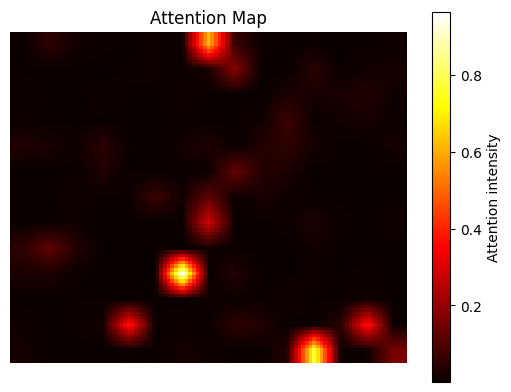

In [16]:
import matplotlib.pyplot as plt

plt.imshow(mask3, cmap='hot')  # mask is your 2D NumPy array
plt.colorbar(label='Attention intensity')
plt.title('Attention Map')
plt.axis('off')
plt.show()

(91, 109)


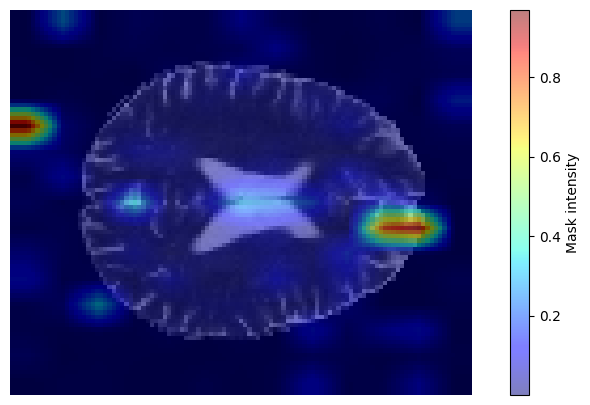

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Example: pick a middle slice along z-axis
slice_idx = x_np.shape[2] // 2  

img_slice = x_np[:, :, slice_idx]
print(img_slice.shape)
mask_slice = mask1

plt.figure(figsize=(10,5))

# Show base image
plt.imshow(img_slice, cmap='gray')

# Overlay mask with transparency
plt.imshow(mask_slice, cmap='jet', alpha=0.5)  # alpha controls overlay strength
plt.colorbar(label="Mask intensity")
plt.axis("off")
plt.show()

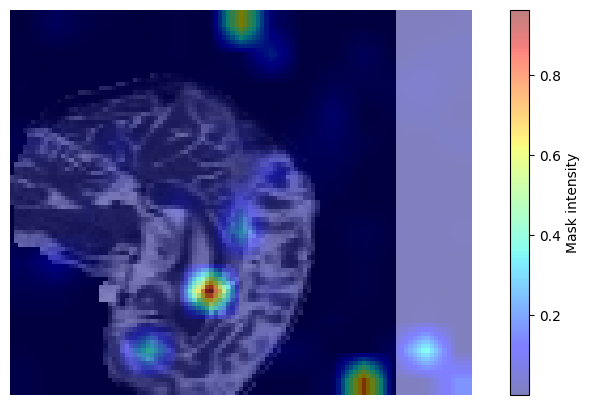

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Example: pick a middle slice along z-axis
slice_idx = x_np.shape[0] // 2  

img_slice = x_np[slice_idx, :, :]
mask_slice = mask3

plt.figure(figsize=(10,5))

# Show base image
plt.imshow(img_slice, cmap='gray')

# Overlay mask with transparency
plt.imshow(mask_slice, cmap='jet', alpha=0.5)  # alpha controls overlay strength
plt.colorbar(label="Mask intensity")
plt.axis("off")
plt.show()

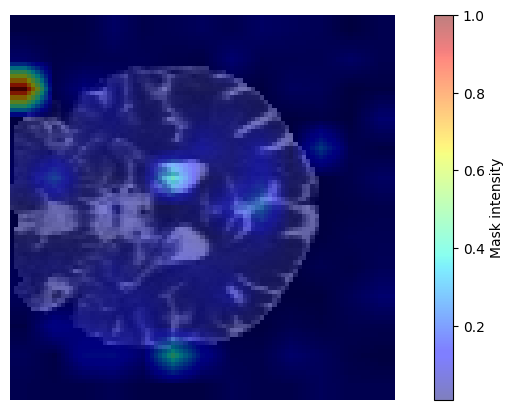

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Example: pick a middle slice along z-axis
slice_idx = x_np.shape[0] // 2  

img_slice = x_np[:, slice_idx, :]
mask_slice = mask2

plt.figure(figsize=(10,5))

# Show base image
plt.imshow(img_slice, cmap='gray')

# Overlay mask with transparency
plt.imshow(mask_slice, cmap='jet', alpha=0.5)  # alpha controls overlay strength
plt.colorbar(label="Mask intensity")
plt.axis("off")
plt.show()